# Frequentist intervals

In lectures we learned a construction of frequentist intervals (the Neyman construction) that is designed to acheive a good coverage. In this notebook, we're going to apply this method to our simple counting experiment and calculate a frequentist interval, and calculate  the coverage of the intervals.  

Remember our Poisson probability distribution can be written as 

$$
P(n;\lambda) \propto \lambda^{n}e^{-\lambda}
$$

where we've dropped the $n!$ in the likelihood (for reasons that will be clear in the future). $\lambda$ is a function of our parameter of interest ($\mu$), given by 

$$
\lambda(\mu) = \mu A\epsilon l + B
$$

This likelihood just says that $n$ is distributed as a Poisson $n\sim \mathrm{Poisson(\lambda(\mu))}$.

As usual, we take negative logs and define, 

$$
q = -2\ln L(\mu) = -2(n\ln(\lambda(\mu)) - \lambda(\mu))
$$


## Neyman intervals with profiled likelihood

We'll start with the Neyman construction for our interval. In this case, we'll calculate a 68% interval (commonly refered to as a 1$\sigma$ interval) on the parameter $\mu$.

In [1]:
%matplotlib inline

import numpy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 12})
#plt.rcParams['figure.figsize'] = (15, 12)


The test statistic  is based on the likelihood ratio, which depends on the value of $\mu$.  

$$
 \zeta_{\mu} = q(\mu) - q(\hat{\mu}) 
$$
if $\hat{\mu}>0$ 
$$
 \zeta_{\mu} = q(\mu) - q(0) 
$$
otherwise.

In [2]:
# All of our definitions are in the python file "counting_model.py"
f=open("counting_model.py")
for line in f.readlines(): print(line),
    
from counting_model import *   

# define the counting experiment

A   = 0.5

eff = 0.9

l   = 1.

k   = 0.3

B   = 0.5

n   = 2 # our measured data


In [3]:
# Poisson mean
def lamb(mu):
    return mu*eff*A*l + B

def hatmu(np):
    return (np-B)/(A*eff*l)

def q(mu,np):
    la = lamb(mu)
    if la<=0: return 0 
    return -2*(np*numpy.log(la) - la)

def qmin(np):
    mumin = hatmu(np)
    la = lamb(mumin)
    if la <=0 : return q(-B/(A*eff*l),np)
    else: 
        return q(mumin,np)


Finally, we have all of the pieces to define our test-statistic.

In [4]:
# calculate test statistic
@numpy.vectorize
def zetal(np,mu):
    mumin=hatmu(np)
    q_value = q(mu,np)
    q_min   = qmin(np)
    if mumin <= 0:
        q_min = q(0,np)
    return q_value-q_min

In [5]:
# return a set of heights for each true value of mu
# for each value, we would mark on where 68% of the distribution lives

def histo_zetal(mu):
  # find the best (profiled) nuisance parameter values for the data (n,0)
  ntoys = 10000
  toy_n   = numpy.random.poisson(lamb(mu),size=ntoys)
  zetal_dist = zetal(toy_n,mu)
  zetal_dist.sort() ; zeta_68 = numpy.quantile(zetal_dist,0.68)
  return zetal_dist, zeta_68

Suppose we observed $n=2$ events. We can take a look at how compatible the data are with the hypothesis defined by $\mu=6$. 

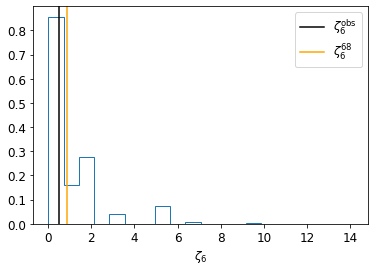

zeta_68= 0.8628710262841945
zeta_obs= 0.519985483017058


In [6]:
zeta_obs_6 = zetal(n,6)

distribution_6, zeta_68_6 =  histo_zetal(6)
plt.hist(distribution_6,bins=20,histtype='step',density=True)
plt.axvline(zeta_obs_6,color='black',label="$\zeta_{6}^{\mathrm{obs}}$")
plt.axvline(zeta_68_6,color='orange',label="$\zeta_{6}^{68}$")
plt.xlabel("$\zeta_{6}$")
plt.legend()
plt.savefig("zeta_6ex.pdf")
plt.show()

print("zeta_68=",zeta_68_6)
print("zeta_obs=",zeta_obs_6)

In this case, the observed value `zeta_obs` is smaller  than `zeta_68`. This means that the observed value is  contained in the part of the distribution that contains 68% of the outcome! So we would accept this point ($\mu=6$) into our 68% interval. 

Now let's repeat for a range of $\mu$ values and report the full interval (i.e the range of points we accept). Note that this takes a little while to run.

In [7]:
l_range   = numpy.arange(0.1,40,0.25)
zeta_range = numpy.arange(0.1,10,0.2)
zeta_obs_vals = []
zeta_68_vals  = []
l_interval = []
densities = []

for l_test in l_range:
  zeta_obs = zetal(n,l_test)
  zetal_toys,zeta_68 = histo_zetal(l_test)

  # we're also keeping a record of all the distributions
  density_vals = plt.hist(zetal_toys,density=True,bins=zeta_range)
  densities.append(density_vals[0])

  zeta_68_vals.append(zeta_68)
  zeta_obs_vals.append(zeta_obs)
  if zeta_obs <= zeta_68 : l_interval.append(l_test)

plt.clf()
# Print out the results
l_l, l_u = min(l_interval),max(l_interval)
l_hat = n
print("interval -> (%.2f,%.2f)"%(l_l,l_u),", l = %.2f + %.2f -%.2f "%(l_hat,l_u-l_hat,l_hat-l_l))

interval -> (1.10,8.10) , l = 2.00 + 6.10 -0.90 


<Figure size 432x288 with 0 Axes>

We can plot the distribution of $\zeta_{\mu}$ for each of our $\mu$ values that we tested. The colour map below shows the density of our test-statistic disribution. We also can overlay the values of $\zeta_{68}$ that we determined. 

/Users/nick/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


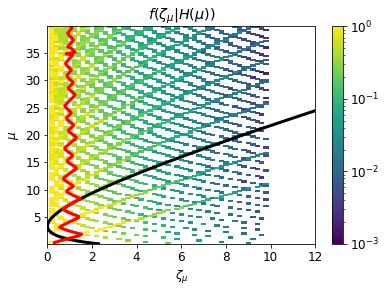

In [8]:
X,Y = numpy.meshgrid(zeta_range,l_range)
c = plt.pcolor(X,Y,densities, \
    norm=LogNorm(vmin=0.001, vmax=1.0))
plt.colorbar(c)
plt.plot(zeta_obs_vals,l_range,color='black',linewidth=3)
plt.plot(zeta_68_vals,l_range,color='red',linewidth=3)
plt.xlabel("$\zeta_{\mu}$")
plt.ylabel("$\mu$")
plt.title("$f(\zeta_{\mu}|H(\mu))$")
plt.xlim(0,12)
plt.savefig("frequentist_interval.pdf")
plt.show()

You can see some odd structures here at small values of $\mu$, that seem to smooth out at larger values. Also the value of  $\zeta_{68}$ seems to settle down at larger values. This will be important for our next topic on coverage and Wilks'  theorem. 

## Coverage

We can check what the coverage of our methods (say for the 68\% interval) by determining the *fraction of intervals* in $\mu$, as a function of the true value $\mu_0$, that contain $\mu_{0}$. 

It sounds like a rather painful ordeal given that calculating a single interval can take time, however, we do not need to calculate each interval to figure out the coverage. 

Remember that $\mu$ is included in the interval provided $\zeta^{\mathrm{obs}}_{\mu}\leq\zeta^{68}_{\mu}$. For the Neyman construction, we can use toys to calculate $\zeta^{68}_{\mu}$.

From Wilks' theorem, we know that the 68% confidence interval can be obtained by picking the values of $\mu$ for which $\zeta^{\mathrm{obs}}_{\mu}\leq1$. We can also calculate the coverage for this method. 


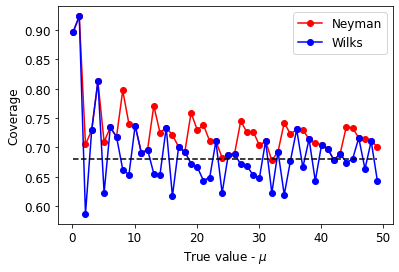

In [9]:
def get_t68_neyman(mu):
  ntoys = 10000
  toy_n   = numpy.random.poisson(lamb(mu),size=ntoys)
  zetal_dist = numpy.array([zetal(np,mu) for np in toy_n])
  zetal_dist.sort() ; zeta_68 = numpy.quantile(zetal_dist,0.68)
  return zeta_68
    
l_range   = numpy.arange(0.1,50,1)
n_coverage_toys = 10000

cov_Neyman, cov_WILKS = [], []
for l_test in l_range:
       # Generate from the profiled value of the nuisance parameter
       # we could also test the coverage under other values!
       toy_n   = numpy.random.poisson(lamb(l_test),size=n_coverage_toys)

       t68_Neyman = get_t68_neyman(l_test)
       t68_WILKS  = 1
       zeta_obs_vals = numpy.array([ zetal(np,l_test) for np in toy_n ])
    
       coverage_Neyman = float(len([x for x in zeta_obs_vals if x <= t68_Neyman ]))/n_coverage_toys
       coverage_WILKS  = float(len([x for x in zeta_obs_vals if x <= t68_WILKS  ]))/n_coverage_toys
       
       cov_Neyman.append(coverage_Neyman)
       cov_WILKS.append(coverage_WILKS)

plt.plot(l_range,cov_Neyman,color='red',marker="o",label="Neyman")
plt.plot(l_range,cov_WILKS,color='blue',marker="o",label="Wilks")

plt.plot(l_range,[0.68 for m in l_range],color='black',linestyle="--")
plt.xlabel("True value - $\mu$")
plt.ylabel("Coverage")
plt.legend()
plt.savefig("coverage_example.pdf")
plt.show()

You can see that the Neyman construction gives very close coverage to the desired 68\% except at small $\mu$, where the discrete nature of the Poisson distribution makes it difficult to find the exact $\zeta^{68}_{\mu}$ - in fact this is still seen at larger values, though the effect gets reduced. Instead, the Wilks method, jumps between over-coverage and undercoverage, eventually settling down only for large values of $\mu$.

Below we plot the distribution of $\zeta_{\mu}$ at $\mu=0.1$ and $\mu=20$. For the larger value, away from the boundary the approximation of a $\chi^{2}(1)$ is  more accurate.

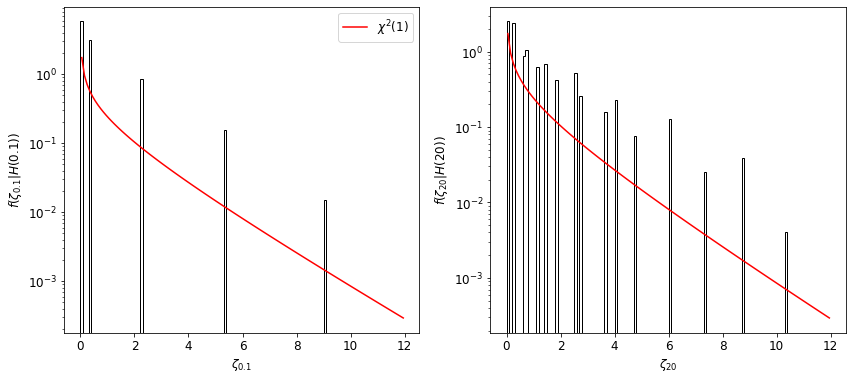

In [11]:
from scipy.stats import chi2

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

chi2vals = chi2.pdf(numpy.arange(0.05,12.05,0.1),df=1)

ax1.hist(histo_zetal(0.1)[0], \
    bins=numpy.arange(0,12,0.1),range=(0,12),\
    color='black',histtype='step',density=True)
ax1.plot(numpy.arange(0.05,12.05,0.1),chi2vals,color='red',label='$\chi^{2}(1)$')
ax2.hist(histo_zetal(20)[0], \
    bins=numpy.arange(0,12,0.1),range=(0,12),\
    color='black',histtype='step',density=True)
ax2.plot(numpy.arange(0.05,12.05,0.1),chi2vals,color='red',label='$\chi^{2}(1)$')

ax1.set_xlabel("$\zeta_{0.1}$")
ax1.set_ylabel("$f(\zeta_{0.1}|H(0.1))$")
ax2.set_xlabel("$\zeta_{20}$")
ax2.set_ylabel("$f(\zeta_{20}|H(20))$")
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
plt.savefig("zlambda_dists_example.pdf")
plt.show()